## Посимвольная языковая модель. Часть 2.

В этом задании Вам нужно использовать написанную языковую модель для генерации воображаемых какслов.

**В процессе написания Вам нужно решить следующие проблемы**:
    
* как запоминать изменившееся состояние модели и передавать его на следующий временной шаг.
* что будет начальным состоянием модели.
* как понять, что слово закончилось и нужно прекратить генерацию.

**Результаты**:

* генератор слов на основе обученной посимвольной модели
* посимвольные вероятности сгенерированных слов

**Дополнительно**:

* ускорение модели за счёт побатчевой генерации

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
def read_dataset(infile):
    df = pd.read_html(infile)
    df = df[0]
    df.columns = ["x", "y"]
    df["y"] = df["y"].astype('str')
    df = df.drop(columns=["x"])
    x = df.y.str.split("\t",expand=True,)
    if x.shape[1] == 3:
        df['word'] = x[0].str.lower()
        df['tag'] = x[2]
    else:
        df['word'] = x[0].str.lower()
        df['tag'] = x[1]
    df = df.drop(columns = ["y"])
    
    words = list(df['word'])
    tags = list(df['tag'])
    return words, tags

train_words, train_tags = read_dataset("russian-train-high")
dev_words, dev_tags = read_dataset("russian-dev")
test_words, test_tags = read_dataset("russian-covered-test")

In [3]:
AUXILIARY = ['\n']

In [4]:
class Vocabulary:
    symbols = 0
    symbol_codes= dict()
    def fit(self, data):
        """Extract unique symbols from the data, make itos (item to string) and stoi (string to index) objects"""
        symbols = set(x for elem in data for x in elem)
        self.symbols = AUXILIARY + sorted(symbols)
        # Запомните следующую строчку кода - она нужна примерно всегда
        self.symbol_codes = {s: i for i, s in enumerate(self.symbols)}
        return self

    def __len__(self):
        return len(self._symbols)

    def transform(self, data):
        """Transform data to indices
        Input:
            - data, list of strings
        Output:
            - list of list of char indices

        >>> self.transform(['word1', 'token2'])
        >>> [[24, 2, 19, 13, 3], [8, 2, 9, 1, 7, 4]]
        """
        max_len = max(map(len, train_words))
        return [[self.symbol_codes[char] for char in word] + 
                [self.symbol_codes[AUXILIARY[0]]]*(max_len - len(word) + 1) for word in data]

In [5]:
v = Vocabulary()
v.fit(train_words)

In [6]:
transforned_train_words = v.transform(train_words)
transforned_dev_words = v.transform(dev_words)
transforned_test_words = v.transform(test_words)

In [9]:
transforned_train_words[:10]

[[5,
  3,
  14,
  14,
  17,
  16,
  20,
  13,
  11,
  12,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [16,
  8,
  10,
  3,
  13,
  17,
  16,
  26,
  8,
  16,
  16,
  30,
  12,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [11,
  20,
  21,
  19,
  35,
  18,
  30,
  5,
  3,
  21,
  31,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [14,
  11,
  26,
  16,
  30,
  12,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [20,
  8,
  19,
  31,
  6,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


## Генератор обучающих данных (батчей):

In [9]:
def batcher(data, batch_size = 4):
    random.shuffle(data)
    data = np.array(data)
    data = data.reshape(int(data.shape[0]/batch_size), batch_size, data.shape[1])
    return data

In [124]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size = 4):
        super(RNN, self).__init__()
        self.hidden_size = (batch_size, hidden_size)
        self.embedding = nn.Embedding(len(v.symbols), input_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        emb = self.embedding(input)
        input_combined = torch.cat((emb, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.hidden_size)
        return torch.nn.init.xavier_uniform_(hidden)

In [129]:
criterion = nn.NLLLoss()

learning_rate = 1e-3

def train(input_line_tensor):
    
    hidden = rnn.initHidden()
    rnn.zero_grad()

    loss = 0
    input_line_tensor = input_line_tensor.T
    n = len(input_line_tensor)
    for i in range(n - 1):
        input = torch.Tensor(input_line_tensor[i]).long()
        target = torch.Tensor(input_line_tensor[i+1]).long()
        output, hidden = rnn(input, hidden)
        l = criterion(output, target)
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / input_line_tensor.shape[0]

In [130]:
num_of_epoch = 10
batch_size = 4

rnn = RNN(10, 32, len(v.symbols), batch_size)
all_losses = []

for _ in range(num_of_epoch):
    b_train = batcher(transforned_train_words, batch_size)
    n_batches = len(b_train)
    print_every = n_batches/20
    plot_every = n_batches/20
    
    for i in range(n_batches):
        _, loss = train(b_train[i])

        if i % print_every == 0:
            print('(%d %d%%) %.4f' % (i, i / n_batches * 100, loss))

        if i % plot_every == 0:
            all_losses.append(loss)

(0 0%) 3.7255
(125 5%) 0.6641
(250 10%) 0.6206
(375 15%) 0.6100
(500 20%) 0.7731
(625 25%) 0.5963
(750 30%) 0.7117
(875 35%) 0.4360
(1000 40%) 0.5486
(1125 45%) 0.6172
(1250 50%) 0.5367
(1375 55%) 0.7510
(1500 60%) 0.7543
(1625 65%) 0.6991
(1750 70%) 0.6763
(1875 75%) 0.4967
(2000 80%) 0.4970
(2125 85%) 0.6835
(2250 90%) 0.4379
(2375 95%) 0.6557
(0 0%) 0.5284
(125 5%) 0.8164
(250 10%) 0.5140
(375 15%) 0.4594
(500 20%) 0.5816
(625 25%) 0.3636
(750 30%) 0.5350
(875 35%) 0.5205
(1000 40%) 0.8309
(1125 45%) 0.6038
(1250 50%) 0.8843
(1375 55%) 0.4459
(1500 60%) 0.6694
(1625 65%) 0.5152
(1750 70%) 0.4451
(1875 75%) 0.4806
(2000 80%) 0.4847
(2125 85%) 0.7587
(2250 90%) 0.4768
(2375 95%) 0.4776
(0 0%) 0.5537
(125 5%) 0.5376
(250 10%) 0.5184
(375 15%) 0.8167
(500 20%) 0.4072
(625 25%) 0.4190
(750 30%) 0.5295
(875 35%) 0.4058
(1000 40%) 0.5196
(1125 45%) 0.5683
(1250 50%) 0.4386
(1375 55%) 0.4956
(1500 60%) 0.4148
(1625 65%) 0.4877
(1750 70%) 0.4234
(1875 75%) 0.4577
(2000 80%) 0.5473
(2125 85%)

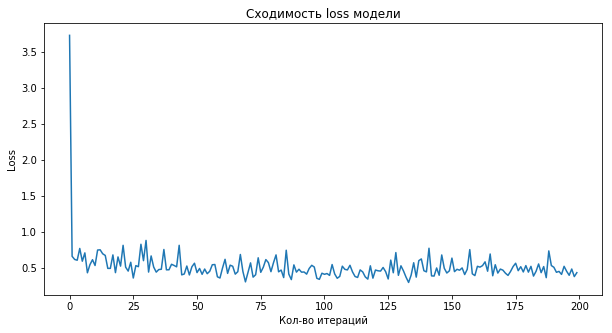

In [213]:
plt.figure(figsize = (10, 5))
plt.title("Сходимость loss модели")
plt.ylabel("Loss")
plt.xlabel("Кол-во итераций")
plt.plot(all_losses)
plt.show()

## Генерация:

что будет начальным состоянием модели?
* на вход нейронной сети мы подадим одну букву и из неё будет генериться слово

как понять, что слово закончилось и нужно прекратить генерацию?
* слово закончилось, когда сгенерирован символ "\n"

Для того, чтобы генерировать разные слова добавили в генерацию немножно случайности. А именно теперь мы будем выбирать первую букву среди самых вероятных с помощью распределения пуассона с параметром $0.5$.

In [206]:
def gen(start_letter = "д"):
    with torch.no_grad():
        result = list()
        hidden = rnn.initHidden()
            
        current_letter = start_letter
        while current_letter[0] != "\n":
            input = torch.Tensor([v.symbol_codes[current_letter]]*batch_size).long()
            
            output, hidden = rnn(input, hidden)
            i = random.choice([0, 1, 2, 3])
            output = output[i]
            output_ind = np.array(-output).argsort()
            
            if(v.symbols[np.argmax(output)] == '\n'):
                pos = output_ind[0]
            else:
                pos = sps.poisson.rvs(mu = 0.5)
            x = output_ind[pos]
            
            current_letter = v.symbols[x]
            t= (current_letter, np.exp(output[x]))
            
            result.append(t)
        return result

Посимвольные вероятности сгенерированных слов (сгенерируем 20 слов):

In [211]:
for i in range(20):
    start_letter = random.choice(v.symbols)
    print("Начальная буква: ", start_letter)
    result = gen(start_letter)
    word = start_letter
    for i in result:
        word += i[0]
        
    print(word)
    print(result)
    print("------------\n")

Начальная буква:  х
ходеривоть

[('о', tensor(0.2875)), ('д', tensor(0.1018)), ('е', tensor(0.1238)), ('р', tensor(0.1424)), ('и', tensor(0.1759)), ('в', tensor(0.1871)), ('о', tensor(0.1155)), ('т', tensor(0.2289)), ('ь', tensor(0.5258)), ('\n', tensor(0.6499))]
------------

Начальная буква:  ц
цатильнывать

[('а', tensor(0.3748)), ('т', tensor(0.1546)), ('и', tensor(0.1581)), ('л', tensor(0.1063)), ('ь', tensor(0.4857)), ('н', tensor(0.3921)), ('ы', tensor(0.6216)), ('в', tensor(0.0251)), ('а', tensor(0.3253)), ('т', tensor(0.4252)), ('ь', tensor(0.9021)), ('\n', tensor(0.7619))]
------------

Начальная буква:  ё
ёровот

[('р', tensor(0.1421)), ('о', tensor(0.2063)), ('в', tensor(0.1400)), ('о', tensor(0.2182)), ('т', tensor(0.1996)), ('\n', tensor(0.1321))]
------------

Начальная буква:  ё
ёраскить

[('р', tensor(0.1304)), ('а', tensor(0.2191)), ('с', tensor(0.1138)), ('к', tensor(0.2251)), ('и', tensor(0.3399)), ('т', tensor(0.0759)), ('ь', tensor(0.6325)), ('\n', tensor(0.6637))

На такого блогера я бы подписалась!